In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random

from PIL import Image
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader

In [3]:
meta_df = pd.read_csv('/content/Meta.csv')
train_df = pd.read_csv('/content/Train.csv')
test_df = pd.read_csv('/content/Test.csv')

data_path = '/content'
train_data_path = os.path.join(data_path, 'Train')
test_data_path = os.path.join(data_path, 'Test')
meta_data_path = os.path.join(data_path, 'Meta')

In [4]:

class TrafficSignsDataset(Dataset):
    def __init__(self, dataframe, images_directory, transform=None):
        # dataframe: 이미지 경로와 클래스 정보를 담은 판다스 데이터프레임
        # images_directory: 이미지 파일들이 저장된 디렉토리 경로
        # transform: 이미지에 적용할 전처리 변환들
        self.dataframe = dataframe
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        # 주어진 인덱스에 해당하는 데이터셋의 샘플 반환
        image_path = os.path.join(self.images_directory, self.dataframe.iloc[index, 7])
        # 이미지 파일을 저장 경로에서 가져옴.
        image = Image.open(image_path).convert('RGB')
        # 클래스 라벨을 PyTorch 텐서로 변환
        label = torch.tensor(self.dataframe.iloc[index, 6], dtype=torch.long)

        # 이미지를 Transform하여 전달.
        if self.transform:
            image = self.transform(image)

        # 변환된 이미지와 레이블을 튜플로 반환
        return image, label


In [5]:
data_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((210, 210)),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_dataset = TrafficSignsDataset(train_df, data_path, transform=data_transforms)
test_dataset = TrafficSignsDataset(test_df, data_path, transform=data_transforms)

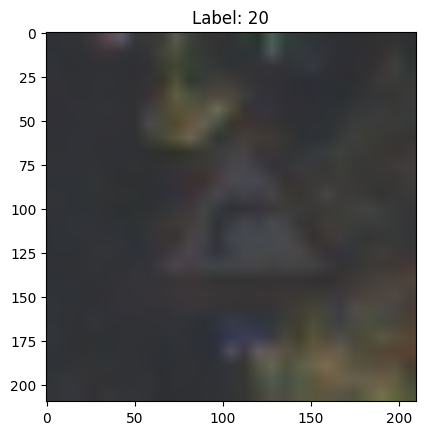

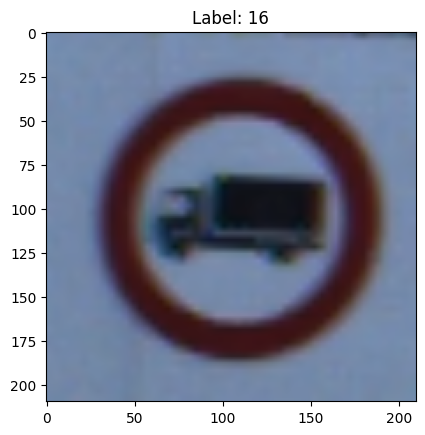

In [6]:
import matplotlib.pyplot as plt

def show_sample(dataset, index):
    image, label = dataset[index]
    image = image.permute(1, 2, 0)  # [C, H, W] -> [H, W, C]
    image = image * 0.5 + 0.5  # 역정규화
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.show()

# 학습 데이터셋의 첫 번째 샘플 보기
show_sample(train_dataset, 0)

# 검증 데이터셋의 첫 번째 샘플 보기
show_sample(test_dataset, 0)


In [7]:
# 학습 및 검증 데이터셋을 Batch 단위로 로드하기 위해서 DatLoader 생성
# 모델이 학습할 때, 순서에 의존하지 않도록 shuffle 설정
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

# DataLoader를 딕셔너리로 저장
dataloaders = {
    'training': train_loader,
    'validation': valid_loader
}

# 각 데이터셋의 크기 저장
dataset_sizes = {
    'training': len(train_loader.dataset),
    'validation': len(valid_loader.dataset)
}

# 데이터셋 크기 출력
print(dataset_sizes)

{'training': 39209, 'validation': 12630}


In [8]:
from tqdm import tqdm
def Train(model, criterion, optimizer, num_epochs, batch_size, dataloaders):
    best_model_weights = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("epoch {}/{}".format(epoch+1, num_epochs))
        print("*" * 10)

        for phase in ["training", "validation"]:
            if phase == "training":
                model.train()  # 학습 모드
            else:
                model.eval()  # 평가 모드

            running_loss = 0.0
            running_accuracy = 0

            # tqdm으로 데이터 로더를 감싸서 진행 상태를 표시
            for data in tqdm(dataloaders[phase], desc=phase):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_accuracy += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_accuracy.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = model.state_dict()

    model.load_state_dict(best_model_weights)

    print('Best validation Accuracy: {:4f}'.format(best_acc))

In [9]:
# ResNet50 모델을 사용
model = torch.hub.load('pytorch/vision:v0.18.0', 'resnet50', pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 43)  # 출력 뉴런 수를 43으로 설정 (클래스 수에 맞게)

# 모델을 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 7
batch_size = 128
# 모델 학습
Train(model, criterion, optimizer, num_epochs, batch_size, dataloaders)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.18.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda
epoch 1/7
**********


training: 100%|██████████| 307/307 [08:20<00:00,  1.63s/it]


training Loss: 0.2106 || Accuracy: 0.9435


validation: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]


validation Loss: 0.1869 || Accuracy: 0.9514
epoch 2/7
**********


training: 100%|██████████| 307/307 [08:18<00:00,  1.62s/it]


training Loss: 0.0339 || Accuracy: 0.9910


validation: 100%|██████████| 99/99 [01:02<00:00,  1.58it/s]


validation Loss: 0.1926 || Accuracy: 0.9523
epoch 3/7
**********


training: 100%|██████████| 307/307 [08:10<00:00,  1.60s/it]


training Loss: 0.0400 || Accuracy: 0.9894


validation: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


validation Loss: 0.1378 || Accuracy: 0.9621
epoch 4/7
**********


training: 100%|██████████| 307/307 [08:13<00:00,  1.61s/it]


training Loss: 0.0221 || Accuracy: 0.9941


validation: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


validation Loss: 0.7111 || Accuracy: 0.8559
epoch 5/7
**********


training: 100%|██████████| 307/307 [08:12<00:00,  1.60s/it]


training Loss: 0.0245 || Accuracy: 0.9938


validation: 100%|██████████| 99/99 [01:02<00:00,  1.57it/s]


validation Loss: 0.0627 || Accuracy: 0.9833
epoch 6/7
**********


training: 100%|██████████| 307/307 [08:11<00:00,  1.60s/it]


training Loss: 0.0074 || Accuracy: 0.9980


validation: 100%|██████████| 99/99 [01:03<00:00,  1.57it/s]


validation Loss: 0.1391 || Accuracy: 0.9682
epoch 7/7
**********


training: 100%|██████████| 307/307 [08:10<00:00,  1.60s/it]


training Loss: 0.0055 || Accuracy: 0.9986


validation: 100%|██████████| 99/99 [01:02<00:00,  1.58it/s]

validation Loss: 0.0846 || Accuracy: 0.9792
Best validation Accuracy: 0.983294
